In [ ]:
###SYNAPTIC TRANSMISSION CORRECT VERSION ********************** (tau_1 - tau_1g)

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d  
from scipy.signal import find_peaks

plt.rcParams.update({'font.size': 18})

# Constants
C = 100  # Total conductance
gL = 50  # Leak conductance
taum = C / gL  # Membrane time constant

EL = -70.   # Leak reversal potential
VT = -50.4  # Threshold potential
DeltaT = 2  # Sharpness of spike initiation
Vcut = VT + 5 * DeltaT  # Cut-off potential

tauw, a, b, Vr = 144, 4, 5, -70.6  

# GABA and AMPA biexponential
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(16, 10))  

frequencies = [100, 200, 300, 400]  # different freqs to test

data_tau_1 = {}

for freq in frequencies:
    for tau_1 in [4]:  # np.arange(1,10,10):    
        for tau_1g in [5]:  # np.arange(1,10,2):   

            g_AMPA_ext_E = 0.1  # nS
            tau_1 = 4  # ms
            tau_2 = 5  # ms
            V_E = 0   # Reversal potential for AMPA

            g_GABA_E = 0.05  # nS
            tau_1g = 5  # ms
            tau_2g = 2  # ms
            V_I = -70  # Reversal potential for GABA

            t = 100
            dt = 0.1
            N = round(t / dt)
            ttotal = np.arange(0, t, dt)

            # signal
            nperiod = 1 / freq * 1000
            tspks = np.arange(10, t, nperiod)
            tspksi = [int(x / dt) for x in tspks]
            tspksf = [int((x + 1) / dt) for x in tspks]
            amp = 1
            syn = np.zeros_like(ttotal)
            for i in range(len(tspksi)):
                syn[tspksi[i]:tspksf[i]] = amp

            vm = EL
            w = b  # Initialize adaptation current
            vmacum = []

            s_AMPA_ext = 0
            x_ampa = 0
            s_GABA = 0
            x_gaba = 0
            Iacum = []

            for i in range(N):
                s_AMPA_ext = s_AMPA_ext + dt * (((tau_2 / tau_1) ** (tau_1 / (tau_2 - tau_1)) * x_ampa - s_AMPA_ext) / tau_1)
                x_ampa = x_ampa + dt * (-x_ampa / tau_2 + syn[i])

                s_GABA = s_GABA + dt * (((tau_2g / tau_1g) ** (tau_1g / (tau_2g - tau_1g)) * x_gaba - s_GABA) / tau_1g)
                x_gaba = x_gaba + dt * (-x_gaba / tau_2g + syn[i])

                I_GABA_rec = g_GABA_E * (vm - V_I) * s_GABA
                I_AMPA_ext = g_AMPA_ext_E * (vm - V_E) * s_AMPA_ext

                Iacum.append(s_GABA - s_AMPA_ext)
                vm = vm + dt * ((gL * (EL - vm) + gL * DeltaT * np.exp((vm - VT) / DeltaT) - I_GABA_rec - I_AMPA_ext - w) / C)
                w = w + dt * ((a * (vm - EL) - w) / tauw)
                if vm > Vcut:
                    vmacum.append(20)
                    vm = Vr
                    w += b
                else:
                    vmacum.append(vm)

            if tau_1 - tau_1g == -1:
                data_tau_1[freq] = (ttotal, Iacum)

plt.figure(figsize=(16, 10))
colors = ['b', 'g', 'r', 'c']
for idx, (freq, (ttotal, Iacum)) in enumerate(data_tau_1.items()):
    peaks, _ = find_peaks(Iacum)
    Iacum = np.asarray(Iacum)
    plt.plot(ttotal[peaks], Iacum[peaks], label=f'{freq} Hz', c=colors[idx])

plt.title(r'Synaptic Transmission $\Delta_{\tau_{rise}}=-1$') 
plt.xlabel('Time (ms)')
plt.ylabel('Synaptic Current (nS)')
plt.legend()
plt.tight_layout()
# plt.savefig('delta_tau_rise_1_correct.png')
# plt.savefig('delta_tau_rise_1_correct.pdf')
plt.show()

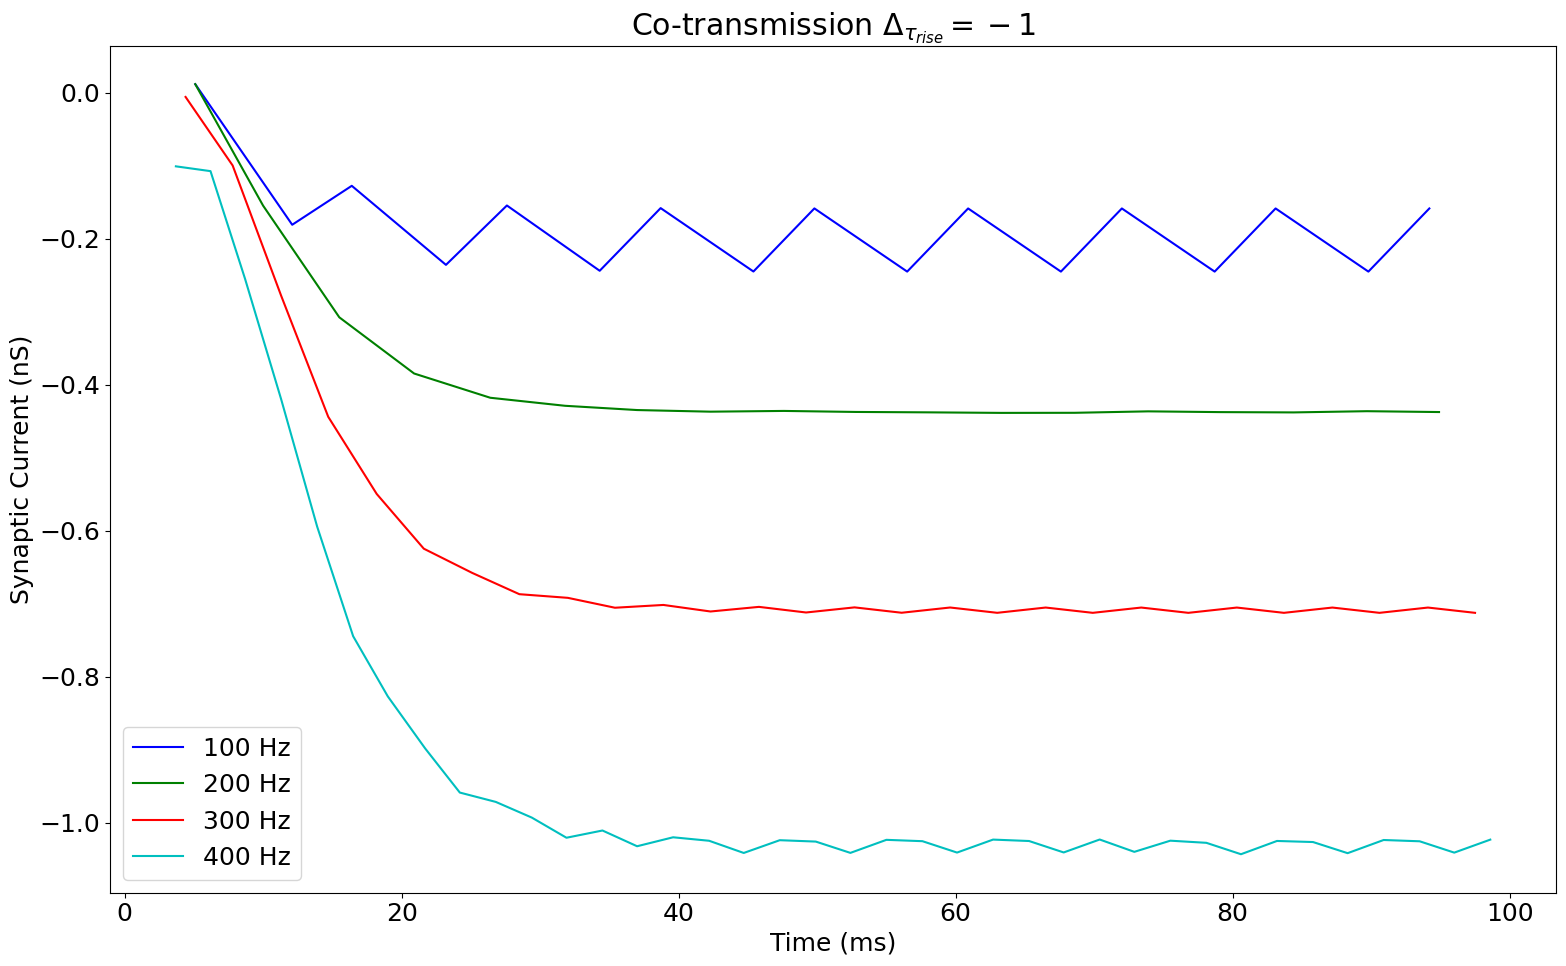

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
plt.rcParams.update({'font.size': 18})

def signal_trend(data):
    if np.argmin(data) > len(data)-3:
        return "decreasing"
    elif np.argmin(data) < 3:
        return "increasing"
    else:
        return "peaking"

delay=0
count=0
width_block=1

frequencies = [100, 200, 300, 400]
colors = ['b', 'g', 'r', 'c']  

plt.figure(figsize=(16, 10))  # single figure for all freqs

# initialize dictionary to store data for co-transmission
data_tau_1_co = {}  

for idx, freq in enumerate(frequencies):
    for a in [4]:  # np.arange(1,10,10):
        for b in [5]:  # np.arange(1,10,2):

            g_AMPA_ext_E = 0.1  # nS
            tau_1 = a  # ms
            tau_2 = 5  # ms

            g_GABA_E = 0.05  # nS
            tau_1g = b  # ms
            tau_2g = 2

            t = 100
            dt = 0.1
            N = round(t / dt)
            ttotal = np.arange(0, t, dt)

            # signal
            tspks = np.linspace(0, t, int(freq / 10))
            tspksi = [int(x / dt) for x in tspks]
            tspksf = [int((x + width_block) / dt) for x in tspks]
            amp = 1
            syn = np.zeros_like(ttotal)
            for i in range(len(tspksi)):
                syn[tspksi[i]:tspksf[i]] = amp

            # different latencies, synaptic input initializations(syn_...), synaptic input assignments (for o in range...)
            # co-transmission
            lat_e = 1
            syn_ampa = np.zeros_like(ttotal)
            for o in range(len(tspksi)):
                syn_ampa[int(tspksi[o] + int(lat_e / dt)):int(tspksf[o] + int(lat_e / dt))] = 1  # Convert to int

            lat_i = 2
            syn_gaba = np.zeros_like(ttotal)
            for o in range(len(tspksi)):
                syn_gaba[int(tspksi[o] + int(lat_i / dt)):int(tspksf[o] + int(lat_i / dt))] = 1  # Convert to int

            s_AMPA = 0
            x_ampa = 0

            s_GABA = 0
            x_gaba = 0

            IacumCo = []

            # neuron parameters
            v_soma = -70
            v_dend = -70
            gleak_soma = 1 * (10 ** -4)
            gleak_dend = 1 * (10 ** -4)
            Eleak_soma = -70
            Eleak_dend = -70
            vacum_soma = []
            vacum_dend = []

            # Coupling parameters (co-transmission)
            g_coupling = 0.01  # coupling conductance

            for i in range(N):
                # separate updates for AMPA and GABA gating variables (co-transmission)
                s_AMPA = s_AMPA + dt * (((tau_2 / tau_1) ** (tau_1 / (tau_2 - tau_1)) * x_ampa - s_AMPA) / tau_1)
                x_ampa = x_ampa + dt * (-x_ampa / tau_2 + syn_ampa[i])

                s_GABA = s_GABA + dt * (((tau_2g / tau_1g) ** (tau_1g / (tau_2g - tau_1g)) * x_gaba - s_GABA) / tau_1g)
                x_gaba = x_gaba + dt * (-x_gaba / tau_2g + syn_gaba[i])

                IacumCo.append(s_GABA - s_AMPA)

                # ionic current for soma
                Ileak_soma = gleak_soma * (v_soma - Eleak_soma)

                # ionic current for dendrite
                Ileak_dend = gleak_dend * (v_dend - Eleak_dend)

                # coupling current
                I_coupling = g_coupling * (v_soma - v_dend)

                # total curent for soma and dendrite 
                I_total_soma = -Ileak_soma - I_coupling + IacumCo[-1]
                I_total_dend = -Ileak_dend + I_coupling

                # update membrane potentials
                v_soma = v_soma + dt * I_total_soma
                v_dend = v_dend + dt * I_total_dend

                vacum_soma.append(v_soma)
                vacum_dend.append(v_dend)

            if a - b == -1:
                data_tau_1_co[freq] = (ttotal, IacumCo)  


for idx, (freq, (ttotal, Iacum)) in enumerate(data_tau_1_co.items()):  
    peaks, _ = find_peaks(Iacum)  
    Iacum = np.asarray(Iacum)  
    plt.plot(ttotal[peaks], Iacum[peaks], label=f'{freq} Hz', c=colors[idx])  

plt.title(r'Co-transmission $\Delta_{\tau_{rise}}=-1$')
plt.xlabel('Time (ms)')
plt.ylabel('Synaptic Current (nS)')
plt.legend()
plt.tight_layout()
# plt.savefig('delta_tau_rise_3_co_correct.png')
# plt.savefig('delta_tau_rise_3_co_correct.pdf')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
from scipy.integrate import simps

plt.rcParams.update({'font.size': 18})

def signal_trend(data):
    if np.argmin(data) > len(data)-3:
        return "decreasing"
    elif np.argmin(data) < 3:
        return "increasing"
    else:
        return "peaking"

def calculate_auc(signal, dt):
    return abs(simps(signal, dx=dt))

delay=0
count=0
width_block=1

frequencies = [100, 200, 300, 400]
colors = ['b', 'g', 'r', 'c']  # Define colors for each frequency

# Initialize lists to store AUCs
synaptic_transmission_aucs = []
co_transmission_aucs = []

# Initialize dictionary to store data for co-transmission
data_tau_3_co = {}  

# Synaptic Transmission AUC Calculation
for freq in frequencies:
    for tau_1 in [4]:  # np.arange(1,10,10):    
        for tau_1g in [7]:  # np.arange(1,10,2):   

            g_AMPA_ext_E = 0.1  # nS
            tau_1 = 4  # ms
            tau_2_values = 5  # ms
            V_E = 0   # Reversal potential for AMPA

            g_GABA_E = 0.05  # nS
            tau_1g = 7  # ms
            tau_2g = 2  # ms
            V_I = -70  # Reversal potential for GABA

            t = 100
            dt = 0.1
            N = round(t / dt)
            ttotal = np.arange(0, t, dt)

            # signal
            nperiod = 1 / freq * 1000
            tspks = np.arange(10, t, nperiod)
            tspksi = [int(x / dt) for x in tspks]
            tspksf = [int((x + 1) / dt) for x in tspks]
            amp = 1
            syn = np.zeros_like(ttotal)
            for i in range(len(tspksi)):
                syn[tspksi[i]:tspksf[i]] = amp

            vm = EL
            w = b  # Initialize adaptation current
            vmacum = []

            s_AMPA_ext = 0
            x_ampa = 0
            s_GABA = 0
            x_gaba = 0
            Iacum = []
          
            for i in range(N):
                s_AMPA_ext = s_AMPA_ext + dt * (((tau_2 / tau_1) ** (tau_1 / (tau_2 - tau_1)) * x_ampa - s_AMPA_ext) / tau_1)
                x_ampa = x_ampa + dt * (-x_ampa / tau_2 + syn[i])

                s_GABA = s_GABA + dt * (((tau_2g / tau_1g) ** (tau_1g / (tau_2g - tau_1g)) * x_gaba - s_GABA) / tau_1g)
                x_gaba = x_gaba + dt * (-x_gaba / tau_2g + syn[i])

                I_GABA_rec = g_GABA_E * (vm - V_I) * s_GABA
                I_AMPA_ext = g_AMPA_ext_E * (vm - V_E) * s_AMPA_ext

                Iacum.append(s_GABA - s_AMPA_ext)
                vm = vm + dt * ((gL * (EL - vm) + gL * DeltaT * np.exp((vm - VT) / DeltaT) - I_GABA_rec - I_AMPA_ext - w) / C)
                w = w + dt * ((a * (vm - EL) - w) / tauw)
                if vm > Vcut:
                    vmacum.append(20)
                    vm = Vr
                    w += b
                else:
                    vmacum.append(vm)

            synaptic_transmission_aucs.append(calculate_auc(Iacum, dt))

# Co-Transmission AUC Calculation
for idx, freq in enumerate(frequencies):
    for a in [4]:  # np.arange(1,10,10):
        for b in [7]:  # np.arange(1,10,2):

            g_AMPA_ext_E = 0.1  # nS
            tau_1 = a  # ms
            tau_2 = 5  # ms

            g_GABA_E = 0.05  # nS
            tau_1g = b  # ms
            tau_2g = 2

            t = 100
            dt = 0.1
            N = round(t / dt)
            ttotal = np.arange(0, t, dt)

            # signal
            tspks = np.linspace(0, t, int(freq / 10))
            tspksi = [int(x / dt) for x in tspks]
            tspksf = [int((x + width_block) / dt) for x in tspks]
            amp = 1
            syn = np.zeros_like(ttotal)
            for i in range(len(tspksi)):
                syn[tspksi[i]:tspksf[i]] = amp

            # different latencies, synaptic input initializations(syn_...), synaptic input assignments (for o in range...)
            # co-transmission
            lat_e = 1
            syn_ampa = np.zeros_like(ttotal)
            for o in range(len(tspksi)):
                syn_ampa[int(tspksi[o] + int(lat_e / dt)):int(tspksf[o] + int(lat_e / dt))] = 1  # Convert to int

            lat_i = 2
            syn_gaba = np.zeros_like(ttotal)
            for o in range(len(tspksi)):
                syn_gaba[int(tspksi[o] + int(lat_i / dt)):int(tspksf[o] + int(lat_i / dt))] = 1  # Convert to int

            s_AMPA = 0
            x_ampa = 0

            s_GABA = 0
            x_gaba = 0

            IacumCo = []

            # neuron parameters
            v_soma = -70
            v_dend = -70
            gleak_soma = 1 * (10 ** -4)
            gleak_dend = 1 * (10 ** -4)
            Eleak_soma = -70
            Eleak_dend = -70
            vacum_soma = []
            vacum_dend = []

            # coupling parameters (co-transmission)
            g_coupling = 0.01  # coupling conductance

            for i in range(N):
                # separate updates for AMPA and GABA gating variables (co-transmission)
                s_AMPA = s_AMPA + dt * (((tau_2 / tau_1) ** (tau_1 / (tau_2 - tau_1)) * x_ampa - s_AMPA) / tau_1)
                x_ampa = x_ampa + dt * (-x_ampa / tau_2 + syn_ampa[i])

                s_GABA = s_GABA + dt * (((tau_2g / tau_1g) ** (tau_1g / (tau_2g - tau_1g)) * x_gaba - s_GABA) / tau_1g)
                x_gaba = x_gaba + dt * (-x_gaba / tau_2g + syn_gaba[i])

                IacumCo.append(s_GABA - s_AMPA)

                # ionic current for soma
                Ileak_soma = gleak_soma * (v_soma - Eleak_soma)

                # ionic current for dendrite
                Ileak_dend = gleak_dend * (v_dend - Eleak_dend)

                # coupling current 
                I_coupling = g_coupling * (v_soma - v_dend)

                # total current for soma and dendrite 
                I_total_soma = -Ileak_soma - I_coupling + IacumCo[-1]
                I_total_dend = -Ileak_dend + I_coupling

                # update membrane potentials
                v_soma = v_soma + dt * I_total_soma
                v_dend = v_dend + dt * I_total_dend

                vacum_soma.append(v_soma)
                vacum_dend.append(v_dend)

            co_transmission_aucs.append(calculate_auc(IacumCo, dt))


co_transmission_aucs = co_transmission_aucs / synaptic_transmission_aucs[0]
synaptic_transmission_aucs = synaptic_transmission_aucs / synaptic_transmission_aucs[0]

# plotting AUCs
x = np.arange(len(frequencies))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, co_transmission_aucs, width, label='Co-Transmission')
rects2 = ax.bar(x + width/2, synaptic_transmission_aucs, width, label='Synaptic Transmission')

ax.set_xlabel('Frequencies')
ax.set_ylabel('AUC')
plt.ylim(0,5)
ax.set_title(r'AUC of Frequencies for Synaptic and Co-transmission at $\Delta{\tau_{rise}}=-7$')
ax.set_xticks(x)
ax.set_xticklabels(frequencies)
ax.legend()

fig.tight_layout()

# plt.savefig('delta_tau_rise_3_auc.png')
# plt.savefig('delta_tau_rise_3_auc.pdf')
plt.show()